In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import statistics as st
import os
import pickle
import glob
from scipy import stats
%matplotlib inline
import random
import seaborn as sn

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
gain = lambda Wb,R,NPE,e:Wb/(NPE*e*R)
NumofPE=lambda Wb,R,g,e:Wb/(R*g*e)

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def getValuesWithSource(files,weight):
    values={} 

    for i in files:
        count=0
        sources={}
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                if(splitline[0] in values.keys()):
                    if(splitline[1] in values[splitline[0]].keys()):
                        values[splitline[0]][splitline[1]]=np.append(values[splitline[0]][splitline[1]],round(int(splitline[2])/weight))
                    else:
                        sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                        values[splitline[0]][splitline[1]]=sources[splitline[1]]
                else:
                    sources={}
                    sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                    values[splitline[0]]=sources
        f.close()
        
    return values
### Photons

## point Source
Point_SolidAngle=lambda r,R:(r**2/(4*R**2))

## Disk Source
### Where A is Rs/d ,and B is Rd/d
Disk_SolidAngle=lambda A,B:(B**2/4)*(1-3/4*(A**2+B**2)+15/8*(1/3*(A**4+B**4)+(A*B)**2)-35/16*(1/4*(A**6+B**6)+3/2*(A*B)**2*(A**2+B**2)))

def getAll(Path):
    Files = glob.glob(Path,recursive=True)
    Values=getValuesWithSource(Files,1)
    return Values
    
def SmearIT(mean,percent):
    return np.random.normal(mean,mean*percent)


In [3]:
### Gains ###
IlkersGains=[3.9e6,2.6e6]
NicksGains=[3.4e6,2.2e6]

In [4]:
## Obtain the Data
Area=PickleITRead("Area.p")

#Area=PickleITRead("AreaWithMinPulse.p")
## Obtain Sim Data
SimData=PickleITRead("Sim.p")


In [5]:
##### Needle Only
#S2_NeedleOnlyPath="/media/ilker/Ilker/SimResults/Sep_28_2022/NeedleOnly/counts_1000/Photon_*.txt"
#S2_NeedleOnlyFiles = glob.glob(S2_NeedleOnlyPath,recursive=True)
#S2_NeedleOnly=getValuesWithSource(S2_NeedleOnlyFiles,1)




#S2_NeedleOnlyInfoPath="/media/ilker/Ilker/SimResults/Sep_28_2022/NeedleOnly/counts_1000/Extra_*.txt"
#S2_infoNeedleOnlyFiles = glob.glob(S2_NeedleOnlyInfoPath,recursive=True)
#S2_info_NeedleOnly=getValuesWithSource(S2_infoNeedleOnlyFiles,1)


### With Needle + Collimator
#S2_NeedleCollimPath="/media/ilker/Ilker/SimResults/Sep_28_2022/Collimator/counts/Photon_*.txt"
#S2_NeedleCollimFiles = glob.glob(S2_NeedleCollimPath,recursive=True)
#S2_NeedleCollim=getValuesWithSource(S2_NeedleCollimFiles,1)


#S2_NeedleCollimInfoPath="/media/ilker/Ilker/SimResults/Sep_28_2022/Collimator/counts/Extra_*.txt"
#S2_NeedleCollimInfoFiles = glob.glob(S2_NeedleCollimInfoPath,recursive=True)
#S2_info_NeedleCollim=getValuesWithSource(S2_NeedleCollimInfoFiles,1)

In [6]:
#values={"Needle":S2_NeedleOnly,
#        "NeedleInfo":S2_info_NeedleOnly,
#        "NeedleColim":S2_NeedleCollim,
#        "NeedleColimInfo":S2_info_NeedleCollim}
#PickleITDump(values,"Sim.p")

In [7]:
### PMT Gains Ilker
Day1_PMT1_GainIL=NumofPE(Area["Day1_Ch1Area_PMT1"],50,IlkersGains[0],1.62e-19)
Day1_PMT3_GainIL=NumofPE(Area["Day1_Ch2Area_PMT3"],50,IlkersGains[1],1.62e-19)
Day2_PMT1_GainIL=NumofPE(Area["Day2_Ch1Area_PMT1"],50,IlkersGains[0],1.62e-19)
Day2_PMT3_GainIL=NumofPE(Area["Day2_Ch2Area_PMT3"],50,IlkersGains[1],1.62e-19)

### PMT Gains Nick
Day1_PMT1_GainNk=NumofPE(Area["Day1_Ch1Area_PMT1"],50,NicksGains[0],1.62e-19)
Day1_PMT3_GainNk=NumofPE(Area["Day1_Ch2Area_PMT3"],50,NicksGains[1],1.62e-19)
Day2_PMT1_GainNk=NumofPE(Area["Day2_Ch1Area_PMT1"],50,NicksGains[0],1.62e-19)
Day2_PMT3_GainNk=NumofPE(Area["Day2_Ch2Area_PMT3"],50,NicksGains[1],1.62e-19)

In [8]:
### PMT1 and PMT3

Po210_SmearedPMT1=np.random.normal(SimData["Needle"]["S1_PHOTOCATHODE"]["Po210"],SimData["Needle"]["S1_PHOTOCATHODE"]["Po210"]*0.026)
Bi210_SmearedPMT1=np.random.normal(SimData["Needle"]["S1_PHOTOCATHODE"]["Bi210"],SimData["Needle"]["S1_PHOTOCATHODE"]["Bi210"]*0.026)

Po210_SmearedPMT3=np.random.normal(SimData["Needle"]["S2_PHOTOCATHODE"]["Po210"],SimData["Needle"]["S2_PHOTOCATHODE"]["Po210"]*0.026)
Bi210_SmearedPMT3=np.random.normal(SimData["Needle"]["S2_PHOTOCATHODE"]["Bi210"],SimData["Needle"]["S2_PHOTOCATHODE"]["Bi210"]*0.026)

In [9]:
#plt.figure(figsize=(12,8),dpi=300)
#plt.title("Delta Function")

#h=plt.hist(Delta,bins=20 ,density=True,stacked=True,label="Delta",alpha=0.3)
#hsmeared=plt.hist(DeltaSmeared,bins=20 ,density=True,stacked=True,label="DeltaSmeared",alpha=0.3)

In [10]:
### Laptop
#path="/home/ilker/Desktop/SimResults/"
### From_External Drive
path="/media/ilker/Ilker/SimResults/"
E1000ms=getAll(path+"Oct_5_2022/1000_events/counts/Extra_*.txt")
#E1000ms=getAll(path+"Dec_16_2022/S2500/counts/Extra_*.txt")

Electrons_1000ms=getAll(path+"Dec_21_2022/counts/Extra_*.txt")
print(Electrons_1000ms)

{'All_e': {'Bi210': array([  243, 15802, 16328, 26505, 37668,  6327, 19532, 31991,   105,
         852,  4692, 27263, 27119,   564, 21613,  2154, 22551, 41358,
       22230, 16278,  4046, 10416,  6264, 22903, 25686, 14238, 22021,
       14827,  3464, 26253,  7302, 24840,  1667, 30081,  3550, 25541,
         555, 19072,   321, 15658,  8389, 24579, 13703, 24263,  5448,
       15139, 24123,  6466, 22466, 12984,  1673, 10767, 19142,  5889,
        2872, 21231, 26111,  8265, 13075, 19746, 13736, 15487, 12359,
       18701,  3788, 31654, 23900, 10206,  7898, 12220,  2795, 24433,
        1493,  1646, 36866, 23943,  6158,  8422, 26448, 28468, 33447,
         708, 27179, 12709, 18388,  5525,  1181, 40430, 29815, 17306,
       18433, 35258, 25698, 30376, 10102,    17, 38296, 24790, 25055,
       19272, 11415, 27354, 18100,  5249,  2679,  7005, 11930,  8667,
          29,  6852,   576, 41257,  4278, 16310,  6544,     6,  7886,
       10840, 15203, 13048,  9851, 19276,  7969, 22975, 13226, 24489,


In [11]:

DetE1000ms=getAll("/media/ilker/Ilker/SimResults/Oct_5_2022/1000_events/counts/Photon_*.txt")
DetE40us=getAll("/media/ilker/Ilker/SimResults/Oct_5_2022/40us/counts/Photon_*.txt")
DetE150us=getAll("/media/ilker/Ilker/SimResults/Oct_5_2022/150us/counts/Photon_*.txt")
DetE100us=getAll("/media/ilker/Ilker/SimResults/Oct_5_2022/100us/counts/Photon_*.txt")

In [12]:
print(np.mean(DetE1000ms["S1_PHOTOCATHODE"]["Po210"][np.where(np.logical_and(DetE1000ms["S1_PHOTOCATHODE"]["Po210"]>=6000,DetE1000ms["S1_PHOTOCATHODE"]["Po210"]<=15000))]))

7656.990123456791


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


791


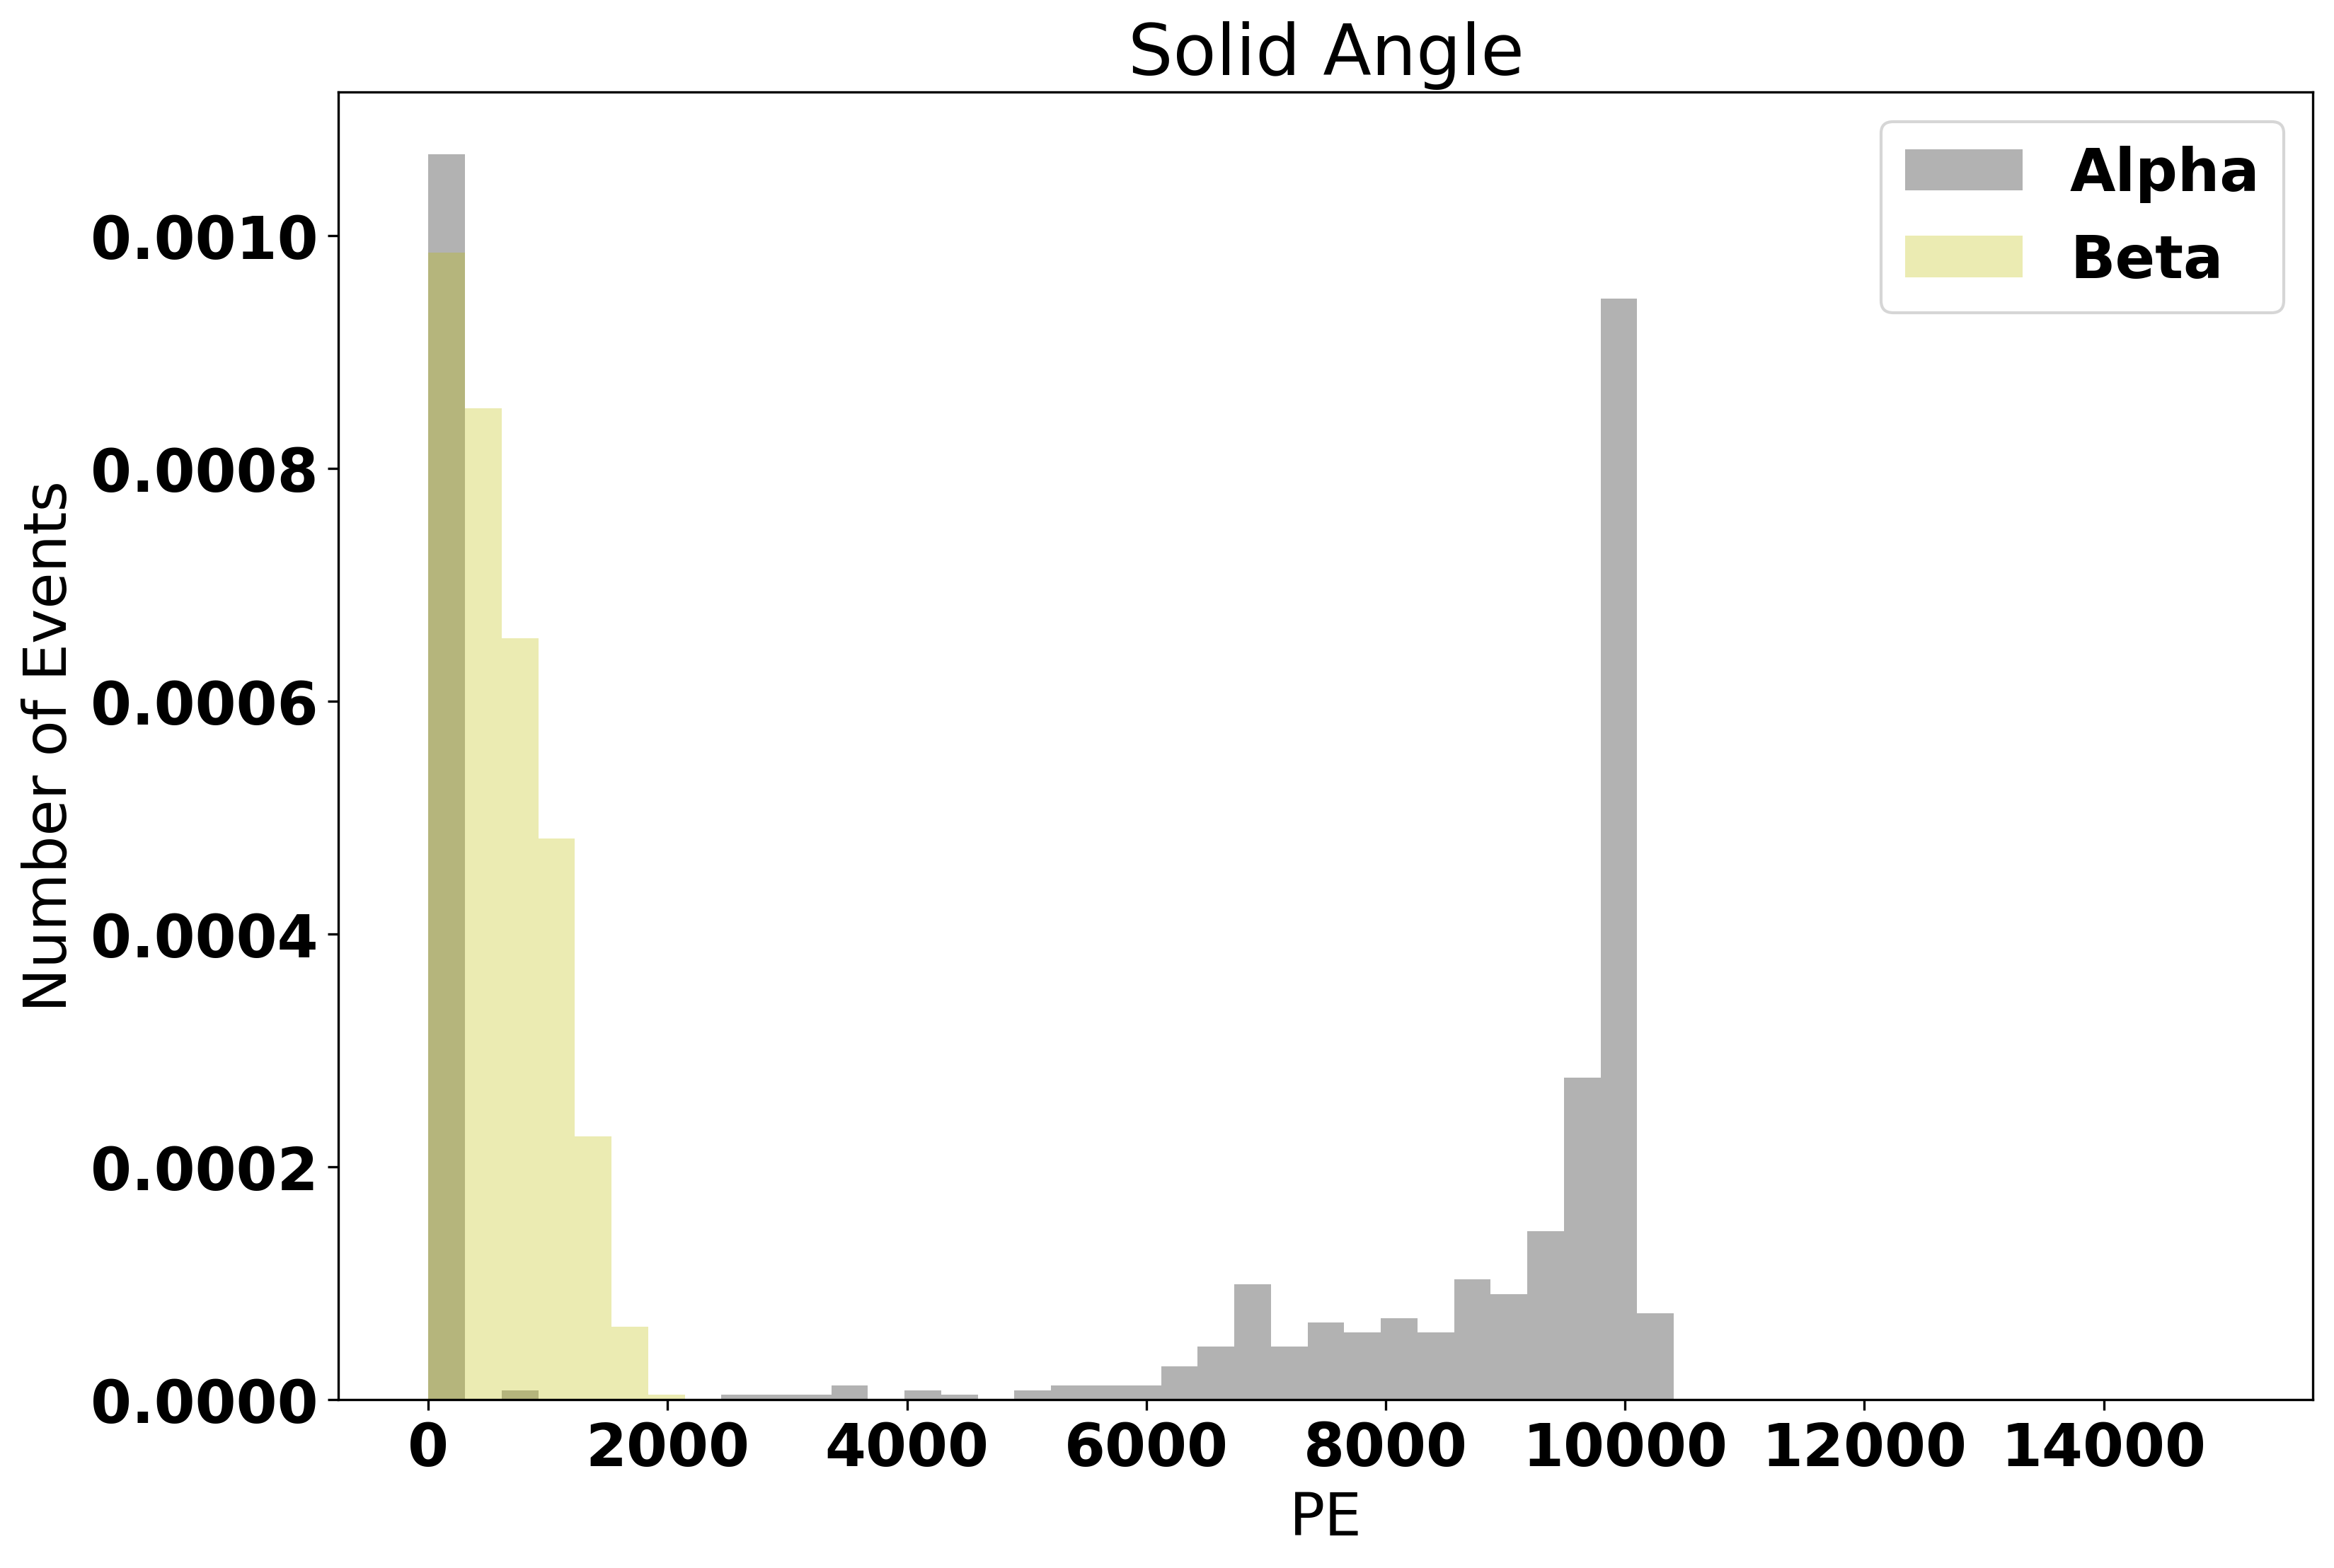

282.9626543209876
1531.7637635030865


In [13]:

Alphas=Electrons_1000ms['All_e']["Po210"]
Betas=Electrons_1000ms['All_e']["Bi210"]
print(len(Alphas))
### Data Comp. Day1

binss=np.linspace(0,15000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Solid Angle")
plt.ylabel("Number of Events")
plt.xlabel("PE")


SolidAngle_AnodeWindowAlphas=Alphas*Point_SolidAngle(0.5,14)*647*0.2
SolidAngle_CathodeWindowAlphas=Alphas*Point_SolidAngle(0.5,36)*647*0.2
SolidAngle_CathodeWindowBetas=Betas*Point_SolidAngle(0.5,36)*647*0.2
SolidAngle_AnodeWindowBetas=Betas*Point_SolidAngle(0.5,14)*647*0.2

#plt.hist(SolidAngle_CathodeWindowAlphas,bins=binss,density=True,stacked=True,label="Alpha",color="k",alpha=0.3)
#plt.hist(SolidAngle_CathodeWindowBetas,bins=binss,density=True,stacked=True,label="Beta",color="y",alpha=0.3)

plt.hist(SolidAngle_AnodeWindowAlphas,bins=binss,density=True,stacked=True,label="Alpha",color="k",alpha=0.3)
plt.hist(SolidAngle_AnodeWindowBetas,bins=binss,density=True,stacked=True,label="Beta",color="y",alpha=0.3)

plt.legend()
plt.show()
#plt.hist(SmearIT(E100us["S1_PHOTOCATHODE"]["Po210"]*0.22,0.14),bins=binss ,density=True,stacked=True,label="Po210_100us",alpha=0.3)
#plt.hist(SmearIT(E100us["S1_PHOTOCATHODE"]["Bi210"]*0.22,0.14),bins=binss ,density=True,stacked=True,label="Bi210",alpha=0.3)
print(np.max(SolidAngle_CathodeWindowBetas))
print(np.max(SolidAngle_CathodeWindowAlphas))

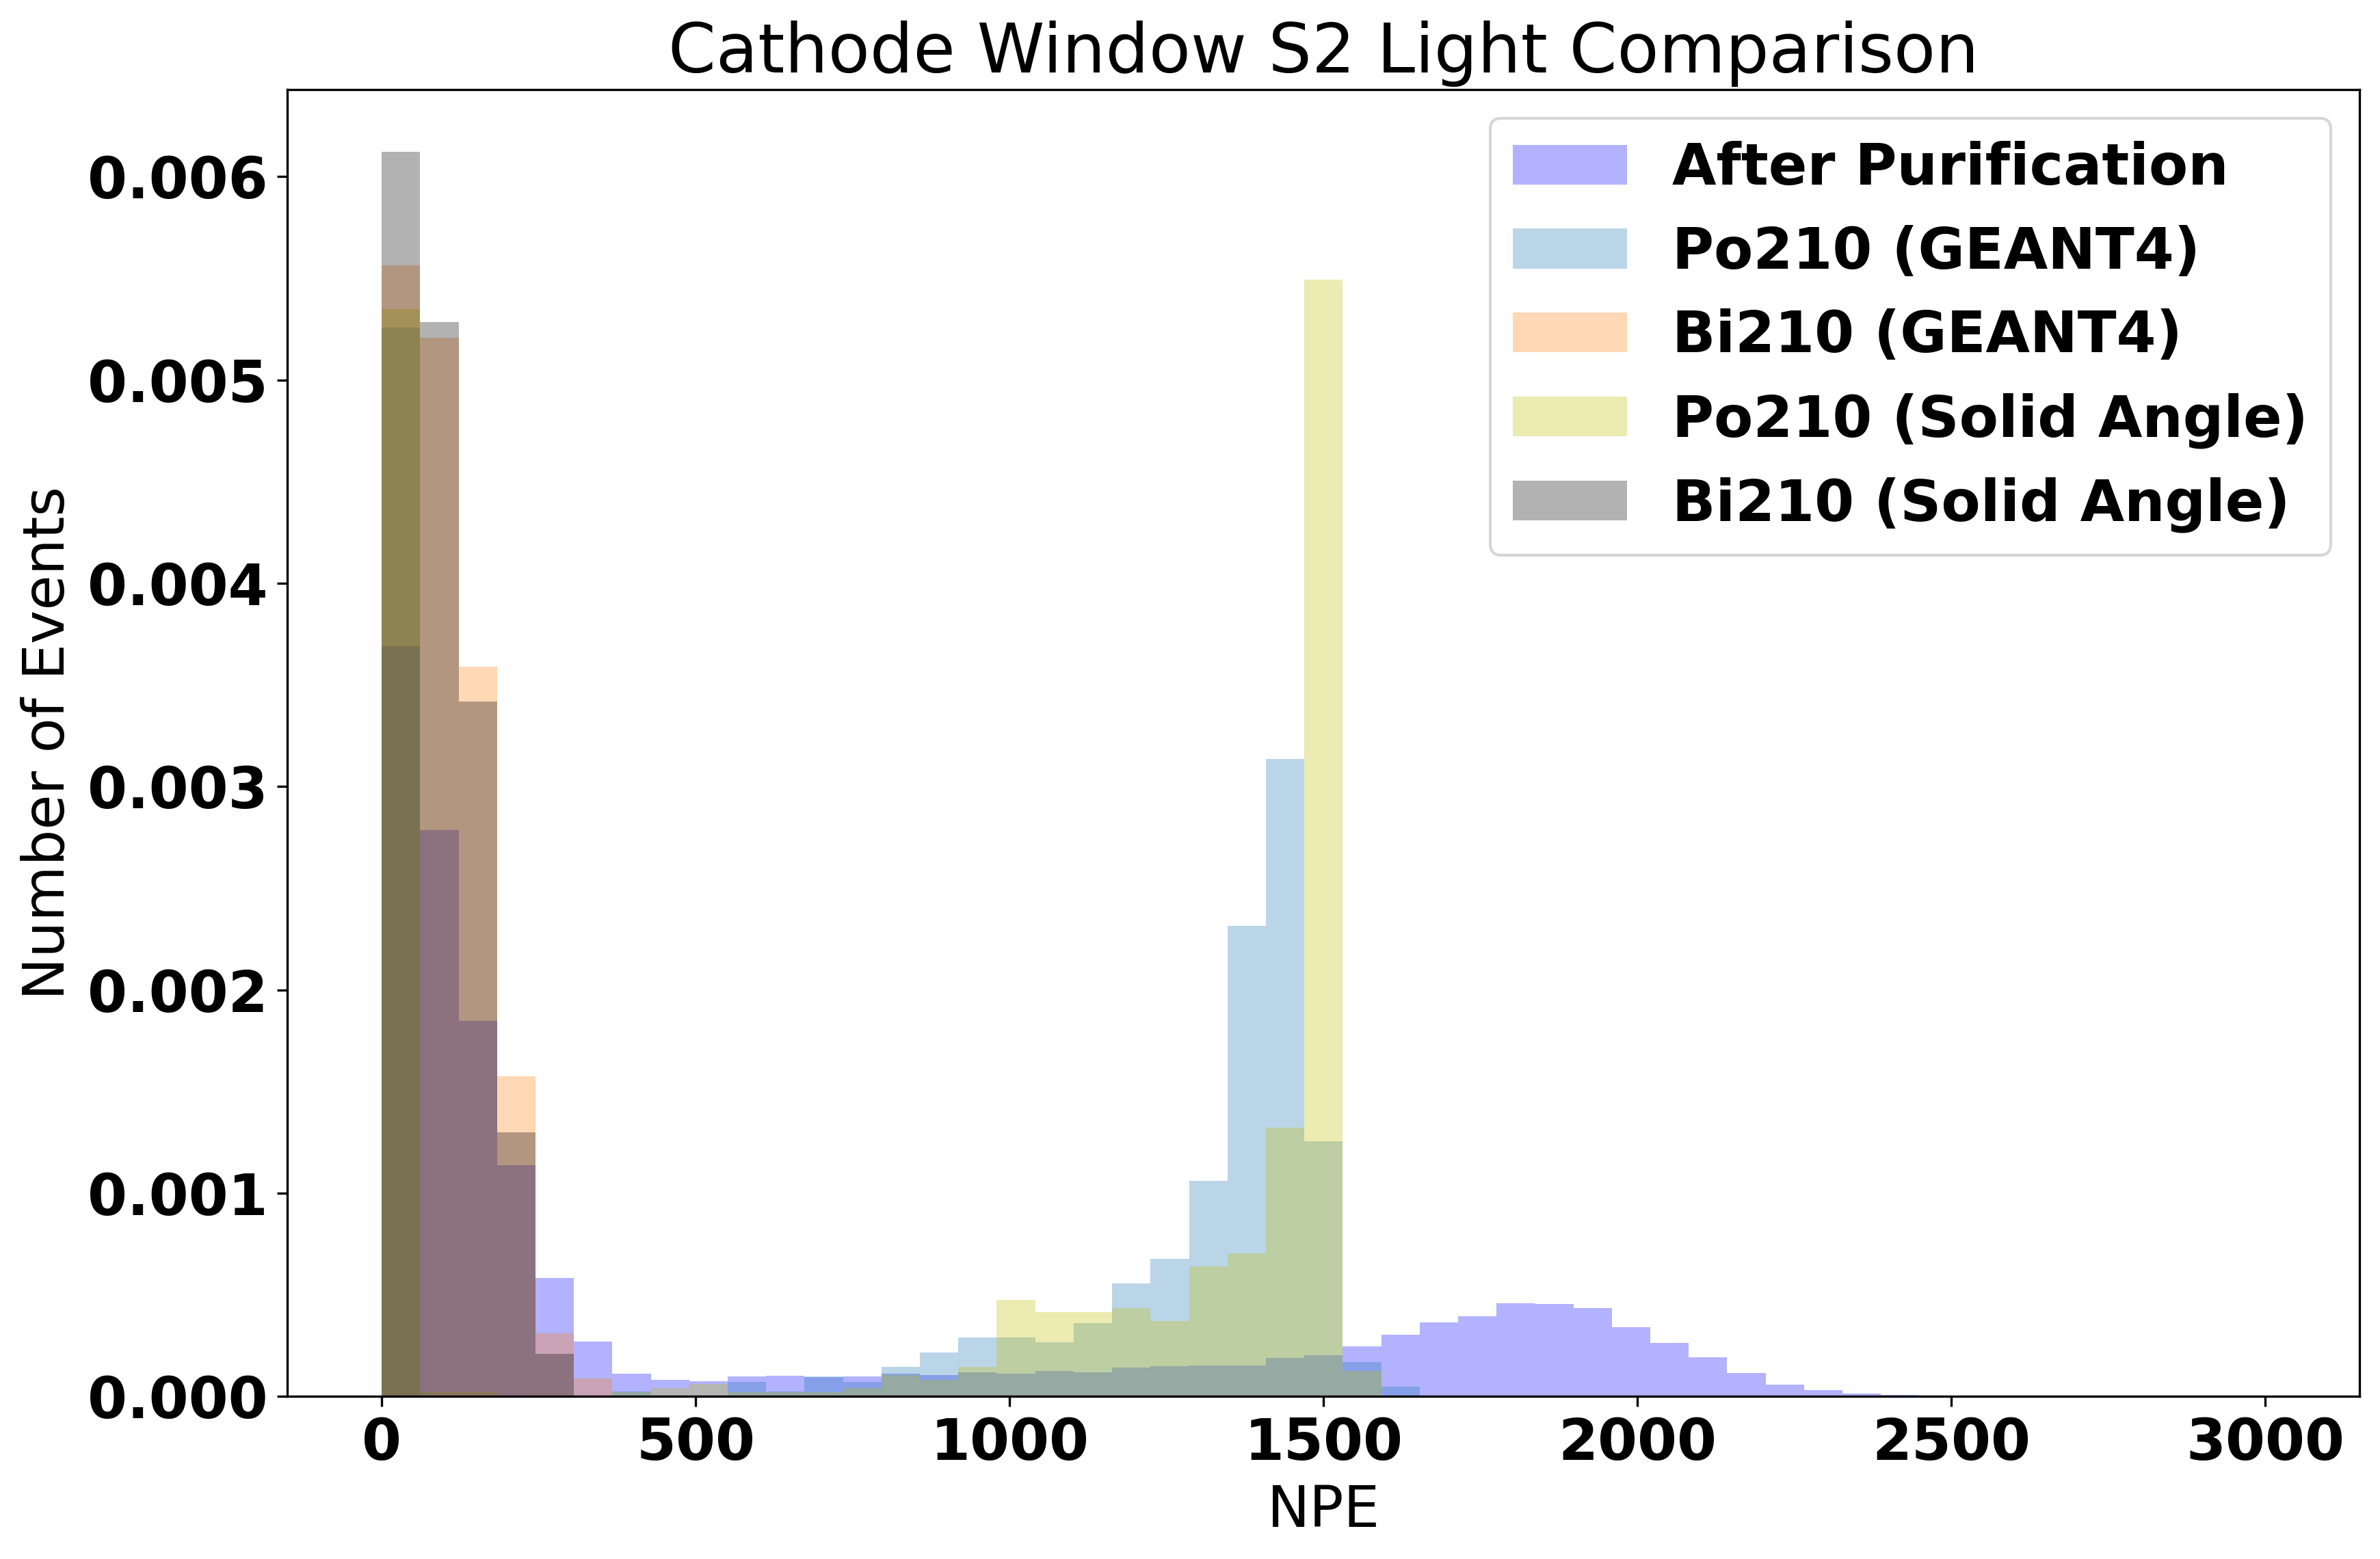

----- Cathode Window S2 Simulation -----
 Alpha Mean --> 895.803924649095 and STD -->629.4966596234575
 Alpha Max --> 1577.7639310995792
 Alpha Min --> 0.18677314991319222
----- Betas -----
 Betas Mean --> 97.93680260152199 and STD -->68.72127914218265
 Betas Max --> 343.11744345303475
 Betas Min --> 0.19495698905925749
----- After Purifaction -----
 Mean --> 635.4371268657569 and STD -->749.6156488721532
 Max --> 3390.3703590021332
 Min --> 0.00019139387028494447
----- Before Purifaction -----
 Mean --> 588.9701761946815 and STD -->394.3757699013145
 Max --> 1623.202150337951
 Min --> 0.027977756875329943


In [25]:
### Data Comp. Day2

binss=np.linspace(0,3000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode Window S2 Light Comparison")
plt.ylabel("Number of Events")
plt.xlabel("NPE")

#plt.hist(Day2_PMT3_GainNk,bins=binss,density=True,stacked=True,label="LED Gain Method 1 (Fitting)",color="r",alpha=0.3)
plt.hist(Day2_PMT3_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
#plt.hist(Day1_PMT3_GainIL,bins=binss,density=True,stacked=True,label="Before Purification",color="r",alpha=0.3)

### Dr Jone's Request to change the QE to 20%
plt.hist(SmearIT(E1000ms["S2_PHOTOCATHODE"]["Po210"]*0.20,0.025),bins=binss ,density=True,stacked=True,label="Po210 (GEANT4)",alpha=0.3)
plt.hist(SmearIT(E1000ms["S2_PHOTOCATHODE"]["Bi210"]*0.20,0.025),bins=binss ,density=True,stacked=True,label="Bi210 (GEANT4)",alpha=0.3)
plt.hist(SolidAngle_CathodeWindowAlphas,bins=binss,density=True,stacked=True,label="Po210 (Solid Angle)",color="y",alpha=0.3)
plt.hist(SolidAngle_CathodeWindowBetas,bins=binss,density=True,stacked=True,label="Bi210 (Solid Angle)",color="k",alpha=0.3)
plt.legend()
#plt.savefig("/home/ilker/Desktop/CRAB_Pictures/PMT3_S2_Light_Yield_Comp.jpeg")

plt.show()

alpha_CathodeWindow=SmearIT(E1000ms["S2_PHOTOCATHODE"]["Po210"]*0.20,0.025)
beta_CathodeWindow=SmearIT(E1000ms["S2_PHOTOCATHODE"]["Bi210"]*0.20,0.025)
print("----- Cathode Window S2 Simulation -----")
print(f" Alpha Mean --> {np.mean(alpha_CathodeWindow)} and STD -->{np.std(alpha_CathodeWindow)}")
print(f" Alpha Max --> {np.max(alpha_CathodeWindow)}")
print(f" Alpha Min --> {np.min(alpha_CathodeWindow)}")

print("----- Betas -----")
print(f" Betas Mean --> {np.mean(beta_CathodeWindow)} and STD -->{np.std(beta_CathodeWindow)}")
print(f" Betas Max --> {np.max(beta_CathodeWindow)}")
print(f" Betas Min --> {np.min(beta_CathodeWindow)}")


########### Data #################


print("----- After Purifaction -----")
print(f" Mean --> {np.mean(Day2_PMT3_GainIL)} and STD -->{np.std(Day2_PMT3_GainIL)}")
print(f" Max --> {np.max(Day2_PMT3_GainIL)}")
print(f" Min --> {np.min(Day2_PMT3_GainIL)}")

print("----- Before Purifaction -----")
print(f" Mean --> {np.mean(Day1_PMT3_GainIL)} and STD -->{np.std(Day1_PMT3_GainIL)}")
print(f" Max --> {np.max(Day1_PMT3_GainIL)}")
print(f" Min --> {np.min(Day1_PMT3_GainIL)}")

betaPE=np.max(beta_CathodeWindow)



In [15]:
#### Condition for Alphas obtained from simulation above ####

PMT3_BeforePurifaction_Alphas_DFiltered=Day1_PMT3_GainIL[np.where(np.logical_and(Day1_PMT3_GainIL>=1000,Day1_PMT3_GainIL<=1500))]
PMT3_AfterPurifaction_Alphas_DFiltered=Day2_PMT3_GainIL[Day2_PMT3_GainIL>betaPE]

alpha_CathodeWindow_G4Filtered=alpha_CathodeWindow[np.where(np.logical_and(alpha_CathodeWindow>=1000,alpha_CathodeWindow<=1500))]
SolidAngle_AlphaCathodeWindow_G4Filtered=SmearIT(SolidAngle_CathodeWindowAlphas[np.where(np.logical_and(SolidAngle_CathodeWindowAlphas>=1000,SolidAngle_CathodeWindowAlphas<=1500))],0.025)
SolidAngle_AlphaCathodeWindow_G4Filtered=SolidAngle_AlphaCathodeWindow_G4Filtered[SolidAngle_AlphaCathodeWindow_G4Filtered>np.max(SolidAngle_CathodeWindowBetas)]
print(f"Mean --> {np.mean(PMT3_BeforePurifaction_Alphas_DFiltered)} and STD -->{np.std(PMT3_BeforePurifaction_Alphas_DFiltered)}")
print(f"Mean --> {np.mean(PMT3_AfterPurifaction_Alphas_DFiltered)} and STD -->{np.std(PMT3_AfterPurifaction_Alphas_DFiltered)}")



Mean --> 1092.4083852262675 and STD -->72.1682097536861
Mean --> 1521.7585663720058 and STD -->491.38911939726626


(array([1.06961652e-03, 0.00000000e+00, 8.25958702e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.12979351e-06, 8.25958702e-06, 8.25958702e-06, 4.12979351e-06,
        0.00000000e+00, 8.25958702e-06, 4.12979351e-06, 0.00000000e+00,
        4.12979351e-06, 8.25958702e-06, 1.65191740e-05, 1.65191740e-05,
        2.89085546e-05, 5.78171091e-05, 7.02064897e-05, 6.19469027e-05,
        5.36873156e-05, 8.25958702e-05, 6.60766962e-05, 5.78171091e-05,
        8.67256637e-05, 1.11504425e-04, 2.27138643e-04, 4.66666667e-04,
        4.79056047e-04, 2.14749263e-04, 4.12979351e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]),
 array([    0.        ,   306.12244898,   612.24489796,   918.36734694,
         1224.48979592,  1530.6122449 

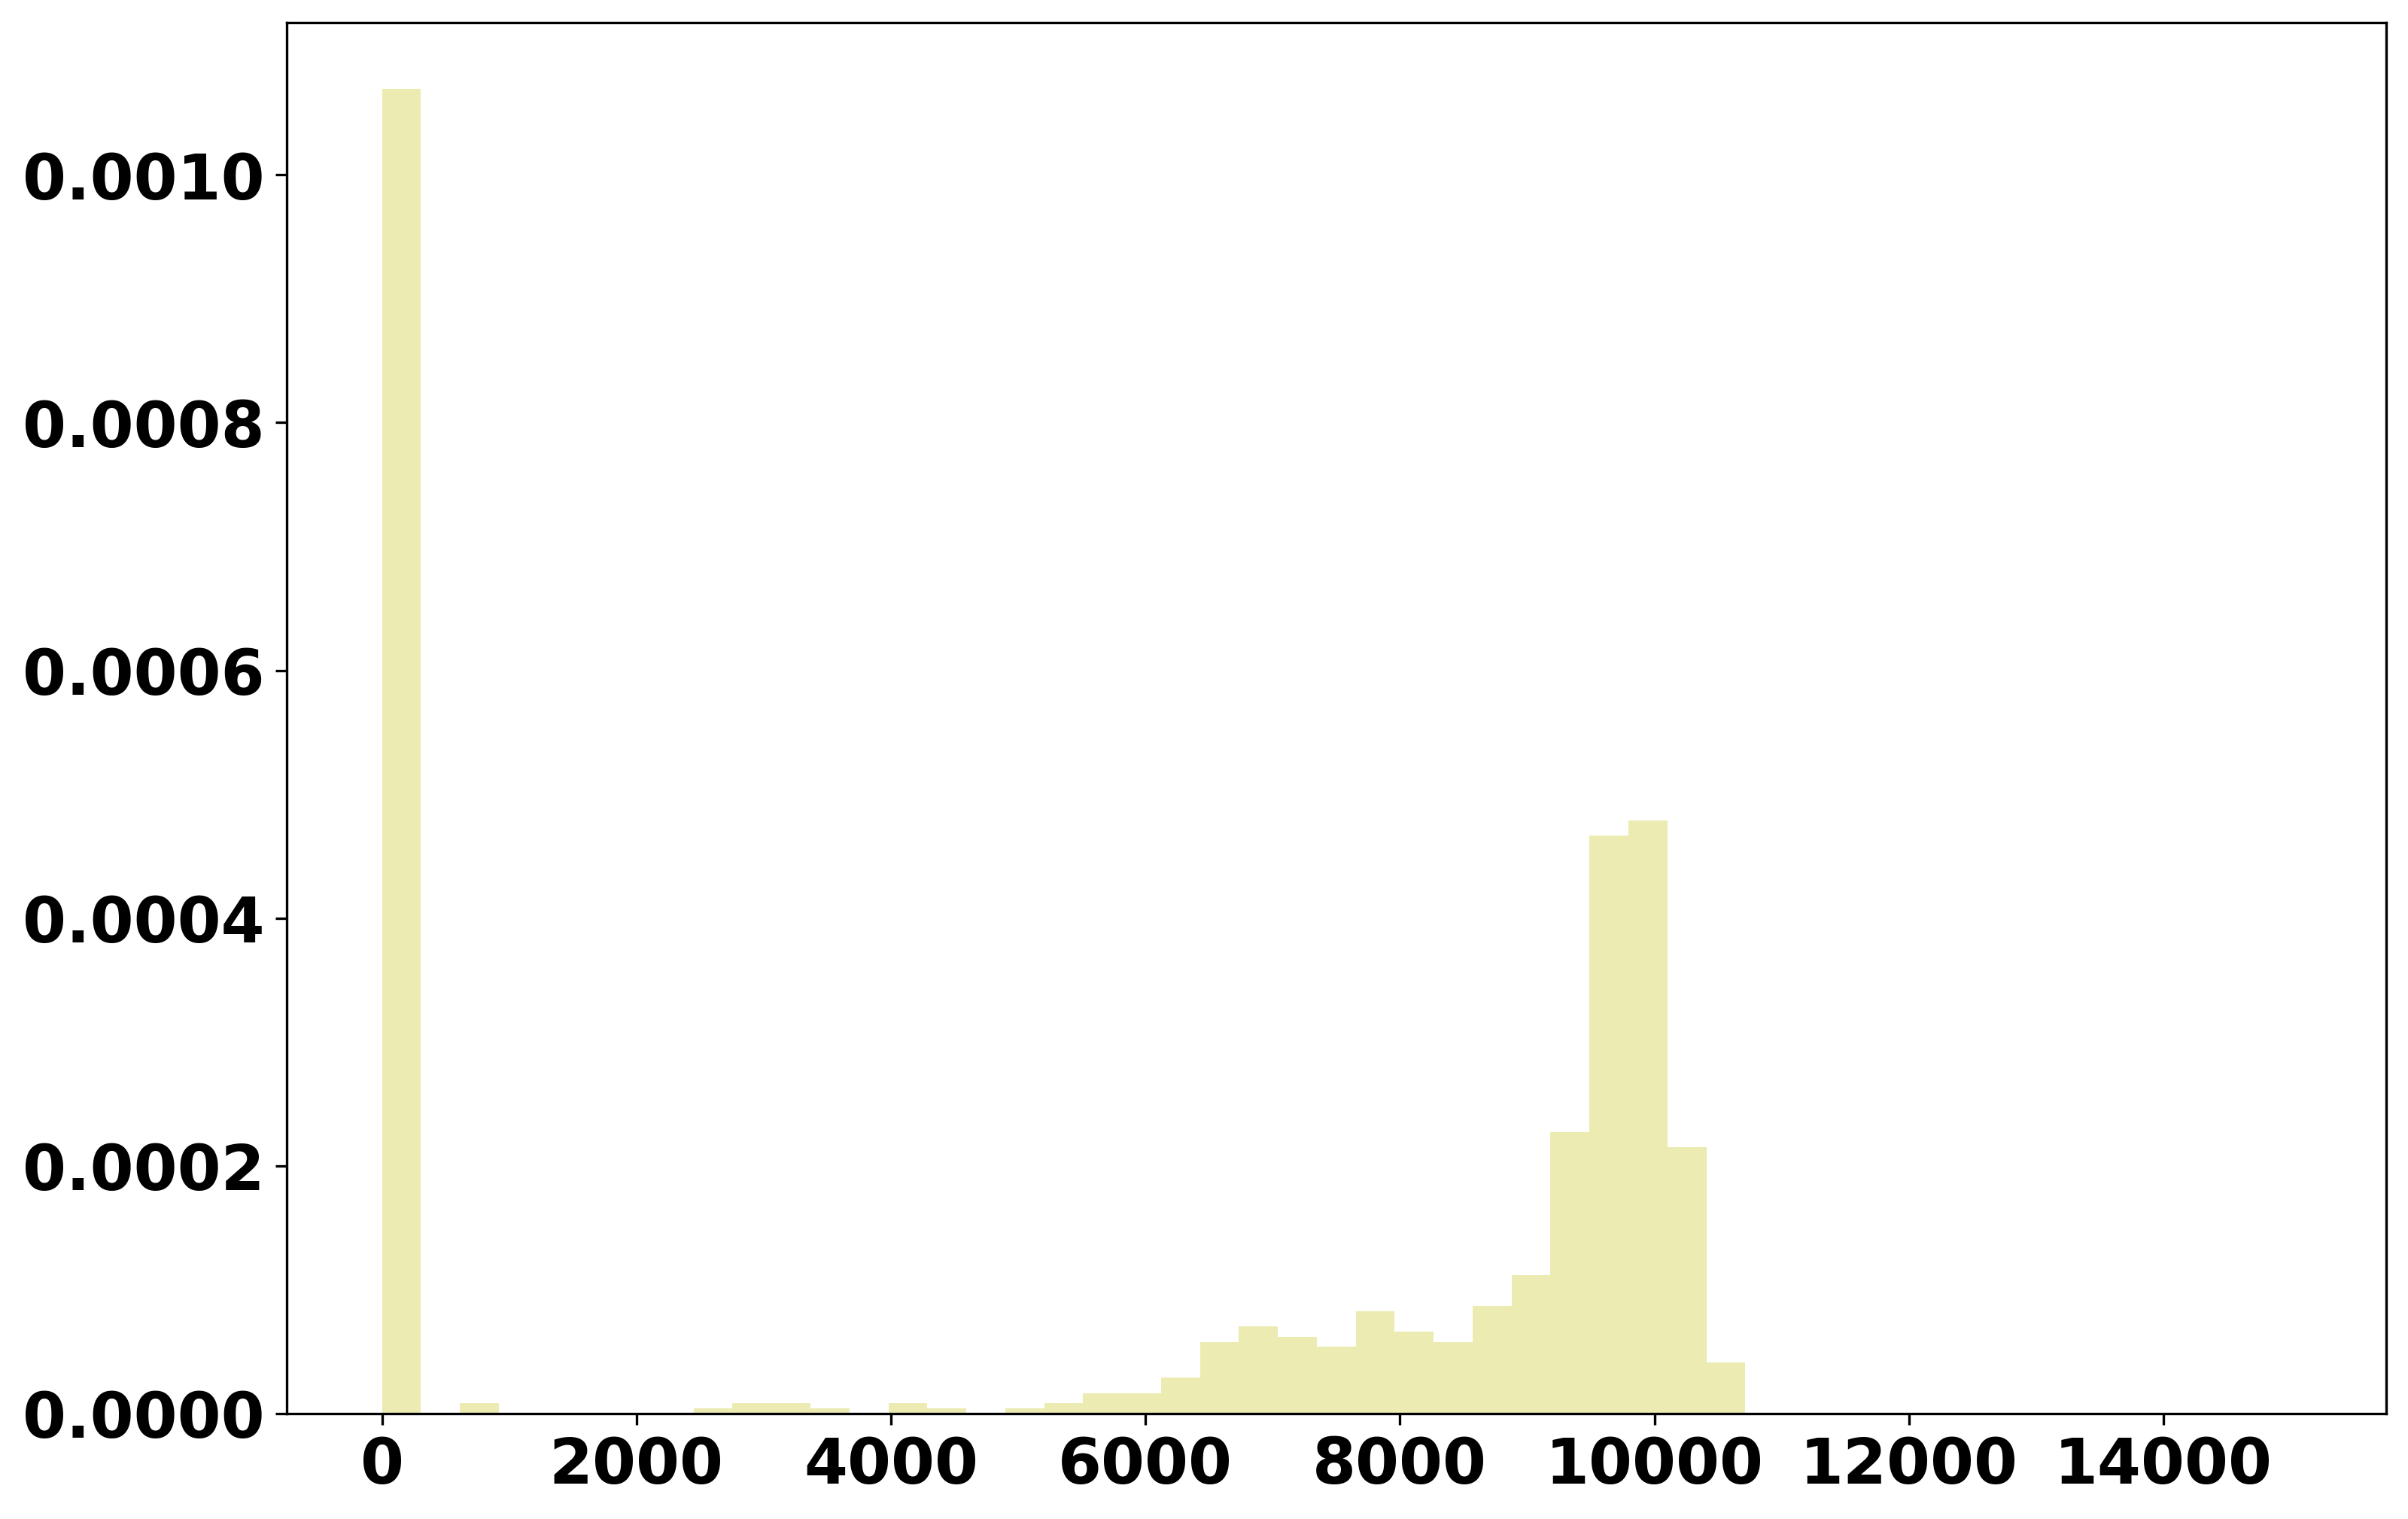

In [16]:

binss=np.linspace(0,15000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.hist(SmearIT(SolidAngle_AnodeWindowAlphas,0.025),bins=binss ,density=True,stacked=True,label="Po210 (SolidAngle)",alpha=0.3,color="y")


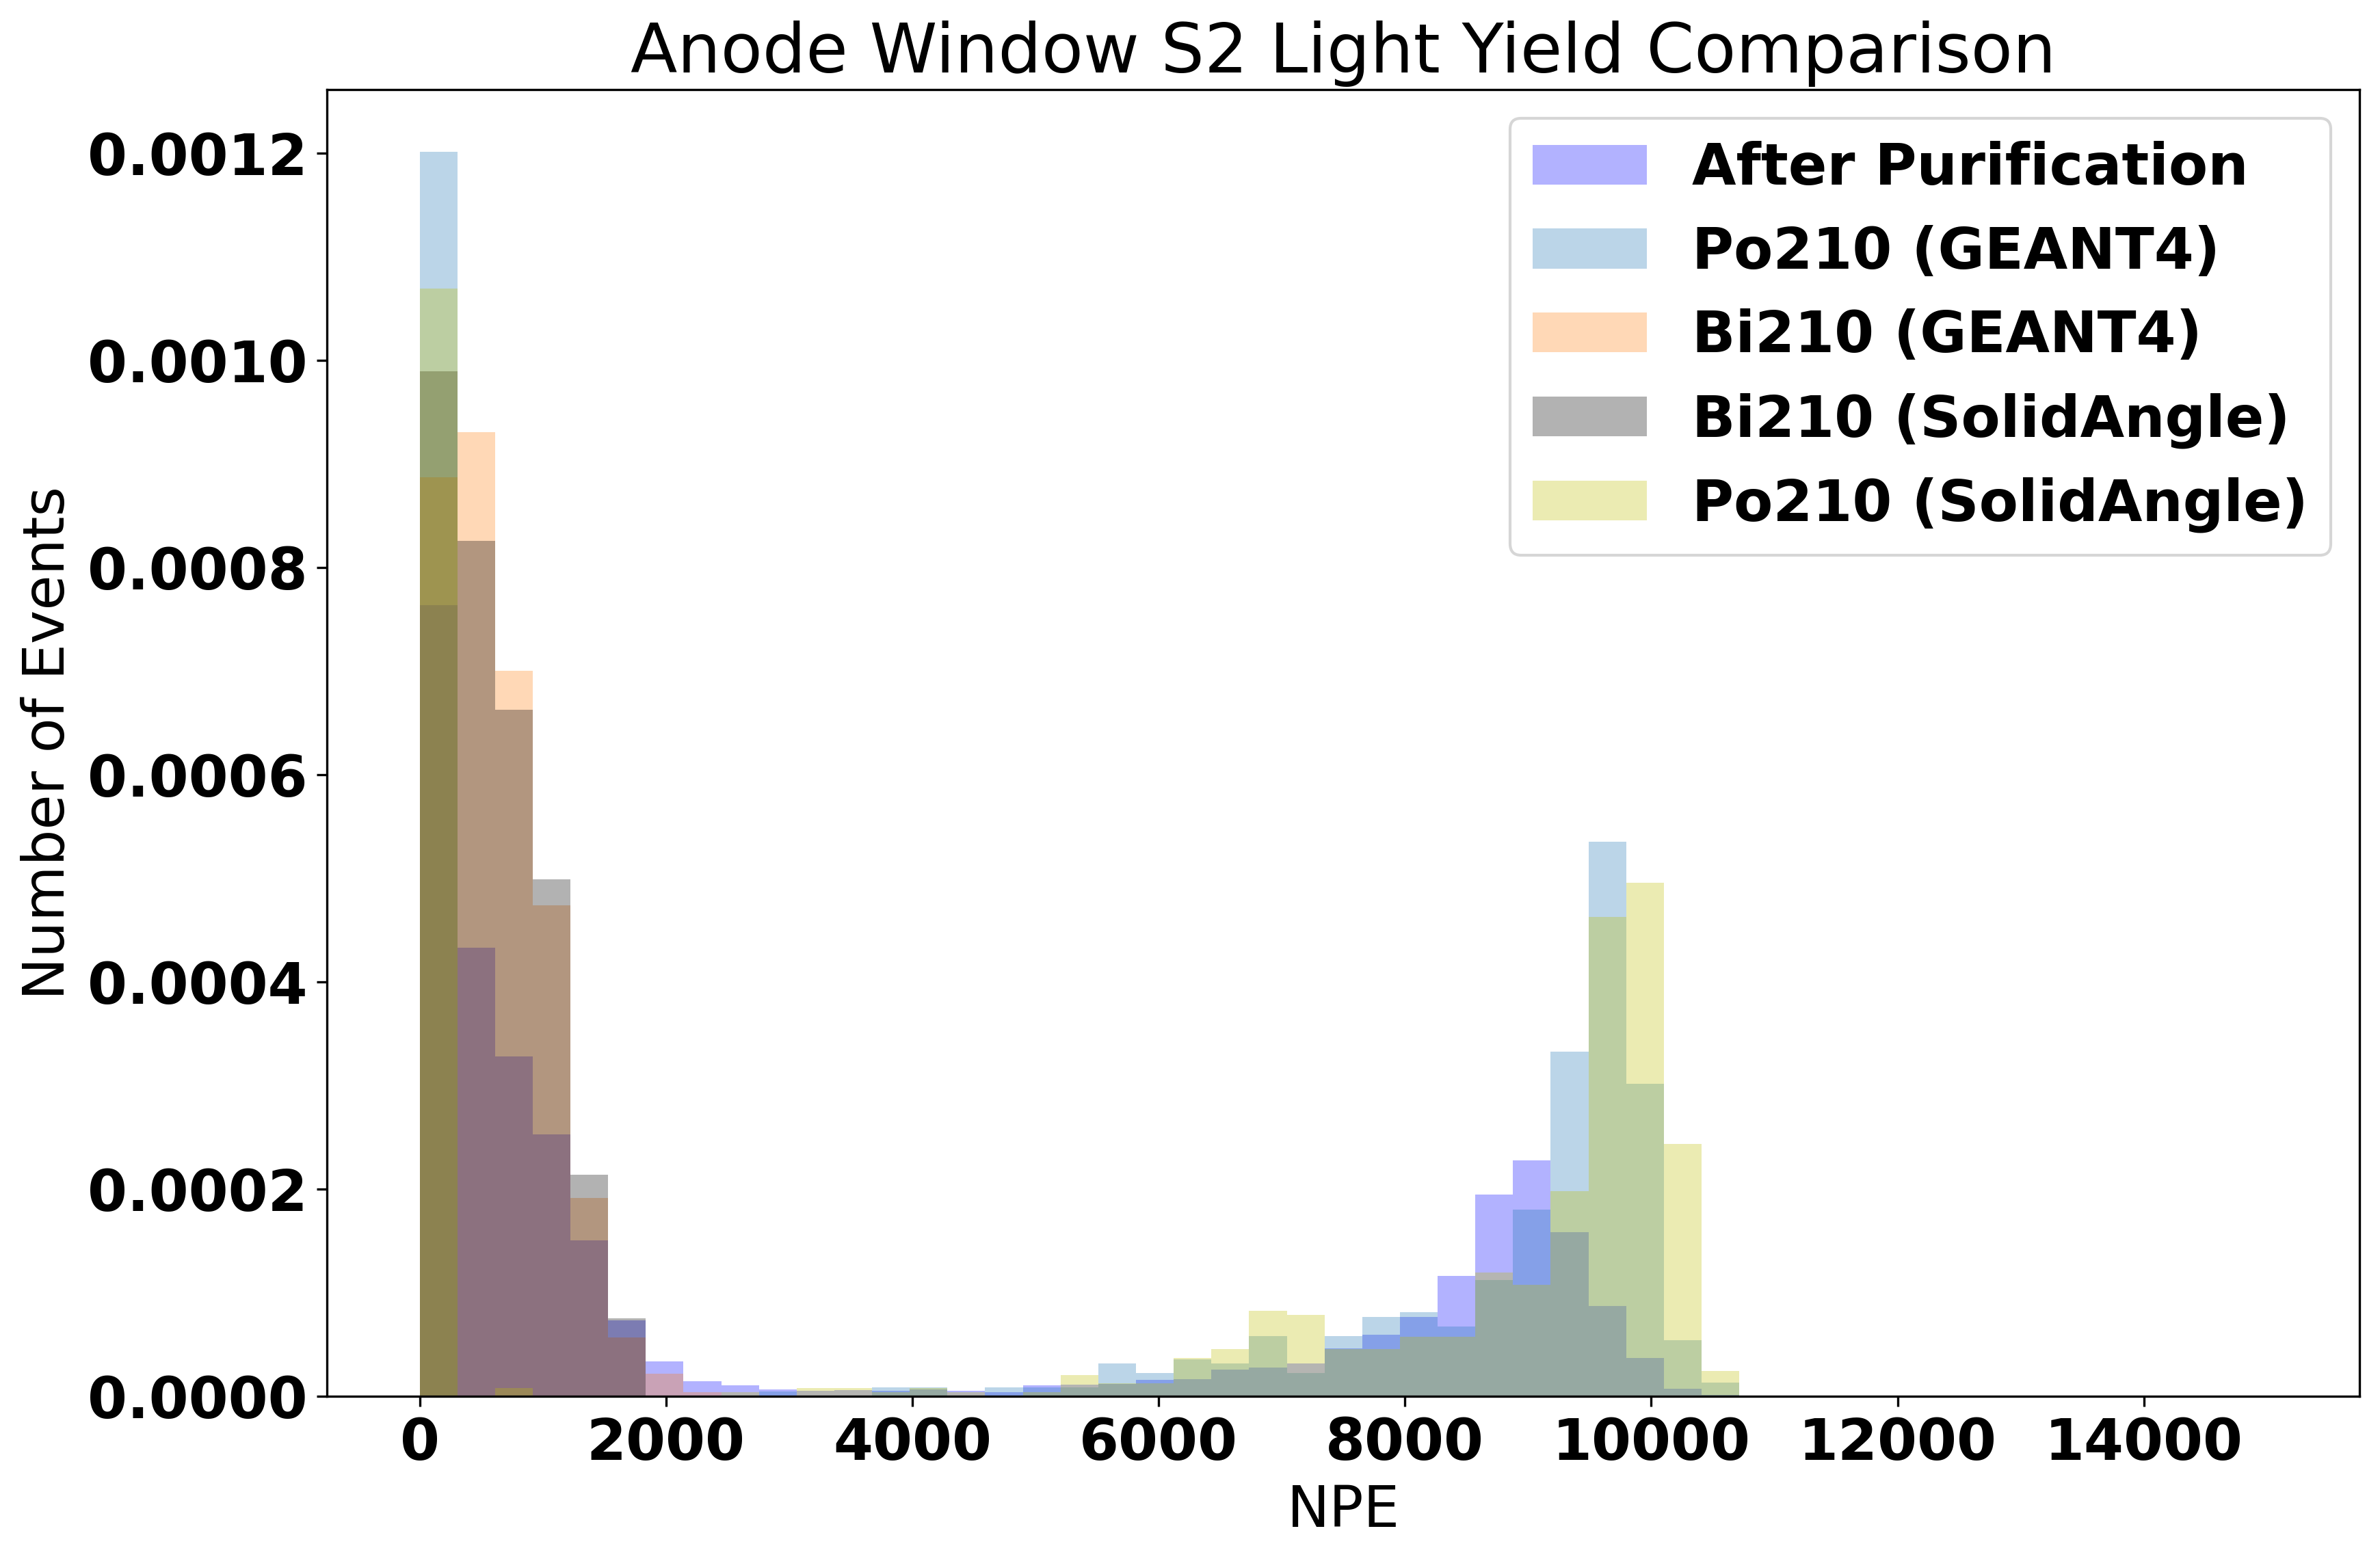

In [23]:
### Data Comp. Day2


binss=np.linspace(0,15000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Anode Window S2 Light Yield Comparison")
plt.ylabel("Number of Events")
plt.xlabel("NPE")

#plt.hist(Day2_PMT1_GainNk,bins=binss,density=True,stacked=True,label="LED Gain Method 1 (Fitting)",color="r",alpha=0.3)
plt.hist(Day2_PMT1_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
#plt.hist(Day1_PMT1_GainIL,bins=binss,density=True,stacked=True,label="Before Purification",color="r",alpha=0.3)

### Dr Jones's request to change the QE to 20%
plt.hist(SmearIT(E1000ms["S1_PHOTOCATHODE"]["Po210"]*0.20,0.025),bins=binss ,density=True,stacked=True,label="Po210 (GEANT4)",alpha=0.3)
plt.hist(SmearIT(E1000ms["S1_PHOTOCATHODE"]["Bi210"]*0.20,0.025),bins=binss ,density=True,stacked=True,label="Bi210 (GEANT4)",alpha=0.3)


plt.hist(SmearIT(SolidAngle_AnodeWindowBetas,0.025),bins=binss ,density=True,stacked=True,label="Bi210 (SolidAngle)",alpha=0.3,color="k")
plt.hist(SmearIT(SolidAngle_AnodeWindowAlphas,0.025),bins=binss ,density=True,stacked=True,label="Po210 (SolidAngle)",alpha=0.3,color="y")
plt.legend()
#plt.savefig("/home/ilker/Desktop/CRAB_Pictures/PMT1_S2_Light_Yield_Comp.jpeg")

plt.show()

In [18]:
alpha_AnodeWindow=SmearIT(E1000ms["S1_PHOTOCATHODE"]["Po210"]*0.20,0.025)
beta_AnodeWindow=SmearIT(E1000ms["S1_PHOTOCATHODE"]["Bi210"]*0.20,0.025)
print("----- Anode Window S2 Simulation -----")
print(f" Alpha Mean --> {np.mean(alpha_AnodeWindow)} and STD -->{np.std(alpha_AnodeWindow)}")
print(f" Alpha Max --> {np.max(alpha_AnodeWindow)}")
print(f" Alpha Min --> {np.min(alpha_AnodeWindow)}")

print("----- Betas -----")
print(f" Betas Mean --> {np.mean(beta_AnodeWindow)} and STD -->{np.std(beta_AnodeWindow)}")
print(f" Betas Max --> {np.max(beta_AnodeWindow)}")
print(f" Betas Min --> {np.min(beta_AnodeWindow)}")


########### Data #################


print("----- After Purifaction -----")
print(f" Mean --> {np.mean(Day2_PMT1_GainIL)} and STD -->{np.std(Day2_PMT1_GainIL)}")
print(f" Max --> {np.max(Day2_PMT1_GainIL)}")
print(f" Min --> {np.min(Day2_PMT1_GainIL)}")

print("----- Before Purifaction -----")
print(f" Mean --> {np.mean(Day1_PMT1_GainIL)} and STD -->{np.std(Day1_PMT1_GainIL)}")
print(f" Max --> {np.max(Day1_PMT1_GainIL)}")
print(f" Min --> {np.min(Day1_PMT1_GainIL)}")

beta_AnodeWindow_PE=np.max(beta_AnodeWindow)

#### Condition for seperating Alphas from betas in data ####

PMT1_BeforePurifaction_Alphas_DFiltered=Day1_PMT1_GainIL[Day1_PMT1_GainIL>beta_AnodeWindow_PE]
PMT1_AfterPurifaction_Alphas_DFiltered=Day2_PMT1_GainIL[np.where(np.logical_and(Day2_PMT1_GainIL>=6000,Day2_PMT1_GainIL<=12000))]
alpha_AnodeWindow_G4Filtered=alpha_AnodeWindow[np.where(np.logical_and(alpha_AnodeWindow>=6000,alpha_AnodeWindow<=12000))]
SolidAngle_AlphaAnodeWindow_G4Filtered=SmearIT(SolidAngle_AnodeWindowAlphas,0.025)
SolidAngle_AlphaAnodeWindow_G4Filtered=SolidAngle_AlphaAnodeWindow_G4Filtered[np.where(np.logical_and(SolidAngle_AlphaAnodeWindow_G4Filtered>=6000,SolidAngle_AlphaAnodeWindow_G4Filtered<=12000))]


print(f"Mean --> {np.mean(PMT1_BeforePurifaction_Alphas_DFiltered)} and STD -->{np.std(PMT1_BeforePurifaction_Alphas_DFiltered)}")
print(f"Mean --> {np.mean(PMT1_AfterPurifaction_Alphas_DFiltered)} and STD -->{np.std(PMT1_AfterPurifaction_Alphas_DFiltered)}")



----- Anode Window S2 Simulation -----
 Alpha Mean --> 5660.00694152539 and STD -->4385.832869105304
 Alpha Max --> 10701.46778402548
 Alpha Min --> 0.18671609322120458
----- Betas -----
 Betas Mean --> 601.8906568718609 and STD -->420.98615860275333
 Betas Max --> 2096.938182932304
 Betas Min --> 0.19621483725182637
----- After Purifaction -----
 Mean --> 3476.0696892532196 and STD -->3845.139688516287
 Max --> 14183.271366327283
 Min --> 0.013391472332462441
----- Before Purifaction -----
 Mean --> 4925.253309525485 and STD -->3199.467587807317
 Max --> 9102.743618203915
 Min --> 0.037072456263681094
Mean --> 6921.668471545112 and STD -->1357.1948067319647
Mean --> 8634.53939903517 and STD -->849.5473530850117


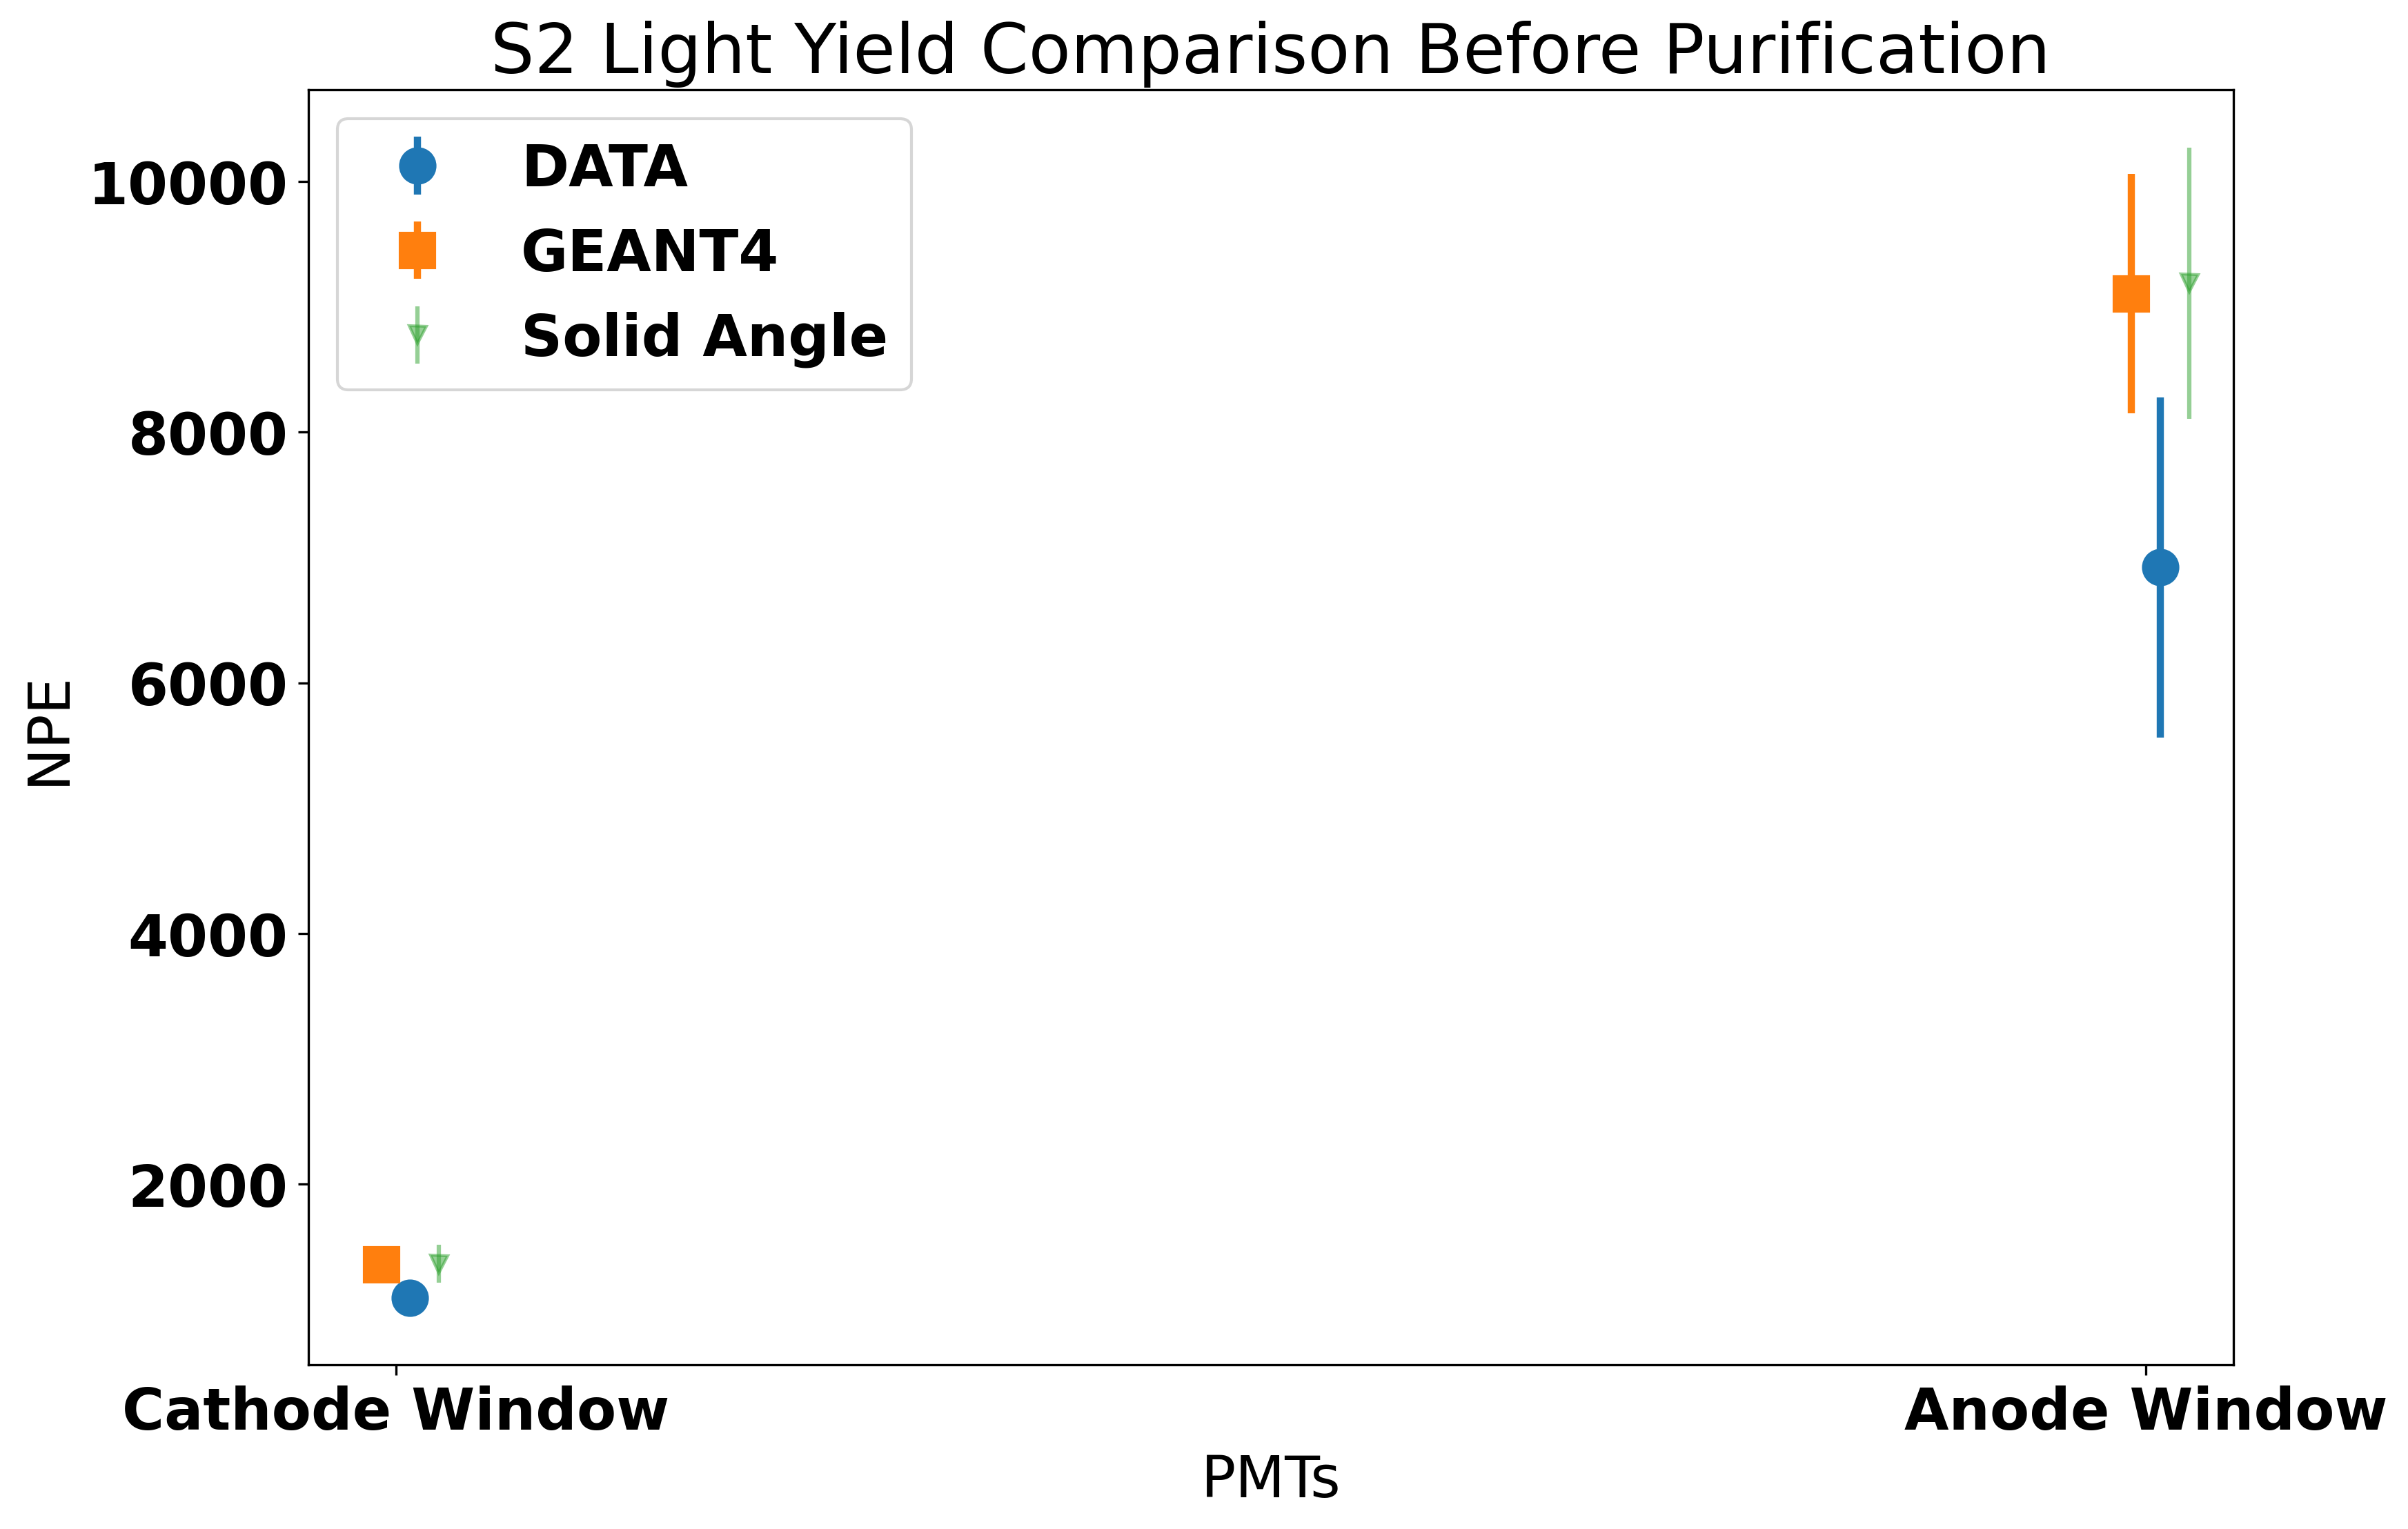

In [19]:
#### This scatter plot compares cathode and anode signals ###
x=["Cathode Window","Anode Window"]

fig=plt.figure(figsize=(12,8),dpi=300)

plt.title("S2 Light Yield Comparison Before Purification")
plt.ylabel("NPE")
plt.xlabel("PMTs")

offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

## Data
ydata=[np.mean(PMT3_BeforePurifaction_Alphas_DFiltered),np.mean(PMT1_BeforePurifaction_Alphas_DFiltered)]
ydataerr=[np.std(PMT3_BeforePurifaction_Alphas_DFiltered),np.std(PMT1_BeforePurifaction_Alphas_DFiltered)]
plt.errorbar(x,ydata,ydataerr,fmt='o',label="DATA",transform=trans+offset(+5),markersize=12,elinewidth=2.5)

## Sim
ysim=[np.mean(alpha_CathodeWindow_G4Filtered),np.mean(alpha_AnodeWindow_G4Filtered)]
ysimerr=[np.std(alpha_CathodeWindow_G4Filtered),np.std(alpha_AnodeWindow_G4Filtered)]

plt.errorbar(x,ysim,ysimerr,fmt='s',alpha=1,label="GEANT4",transform=trans+offset(-5),markersize=12,elinewidth=2.5)

## SolidAngle sim
ysolid=[np.mean(SolidAngle_AlphaCathodeWindow_G4Filtered),np.mean(SolidAngle_AlphaAnodeWindow_G4Filtered)]
ysoliderr=[np.std(SolidAngle_AlphaCathodeWindow_G4Filtered),np.std(SolidAngle_AlphaAnodeWindow_G4Filtered)]

plt.errorbar(x,ysolid,ysoliderr,fmt='v',alpha=0.5,label="Solid Angle",transform=trans+offset(+15))
plt.legend(loc='upper left')
plt.savefig("/media/ilker/Ilker/CRAB/Pictures/S2_Scatter_BeforePurifcation.png")
plt.show()


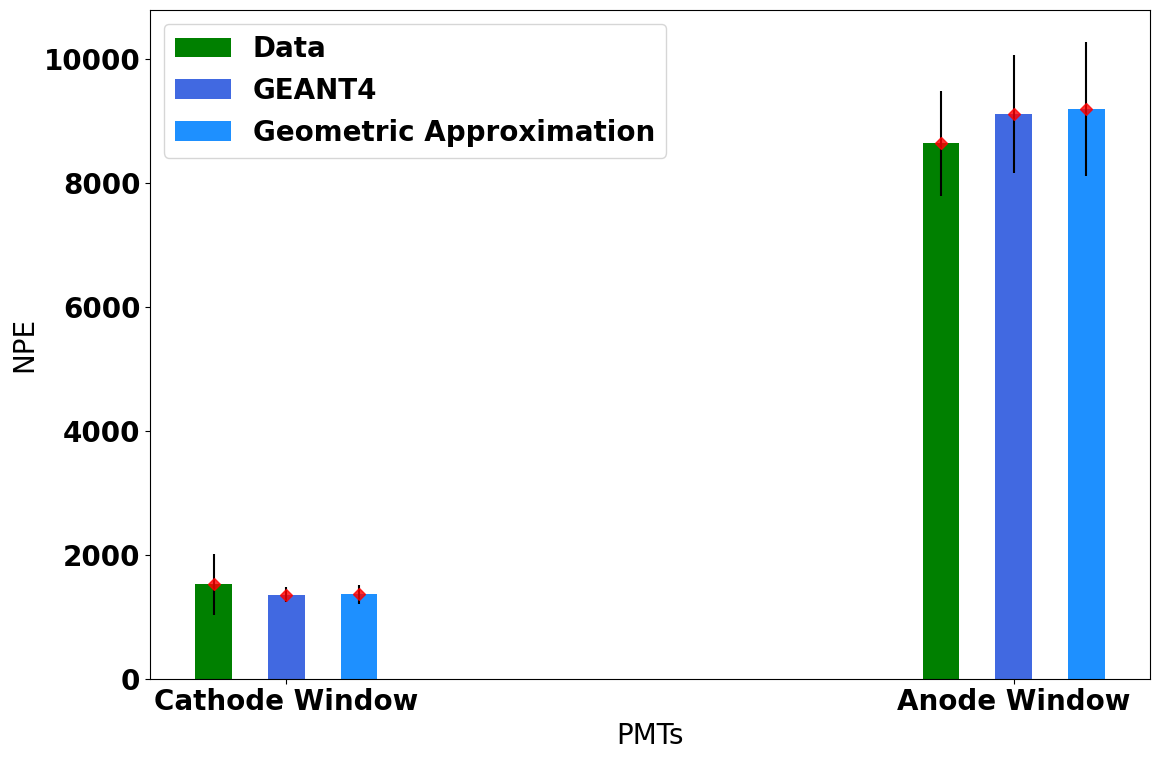

In [20]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

ydata=[np.mean(PMT3_AfterPurifaction_Alphas_DFiltered),np.mean(PMT1_AfterPurifaction_Alphas_DFiltered)]
ydataerr=[np.std(PMT3_AfterPurifaction_Alphas_DFiltered),np.std(PMT1_AfterPurifaction_Alphas_DFiltered)]


ind = np.arange(2) # the x locations for the groups
width = 0.05 # the width of the bars
shift=-0.05
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width+shift, ydata, width, yerr=ydataerr, label='Data',color="green",linewidth=10)
ax.plot(ind - width+shift,ydata,  marker="D", linestyle="", alpha=0.8, color="r")

rects2 = ax.bar(ind + width+shift, ysim, width, yerr=ysimerr, label='GEANT4',color="royalblue",linewidth=10)
ax.plot(ind + width+shift,ysim,  marker="D", linestyle="", alpha=0.8, color="r")

rects2 = ax.bar(ind + 3*width+shift, ysolid, width, yerr=ysoliderr, label='Geometric Approximation',color="dodgerblue",linewidth=10)
ax.plot(ind + 3*width+shift,ysolid,  marker="D", linestyle="", alpha=0.8, color="r")

ax.set_ylabel('NPE')
ax.set_xlabel('PMTs')
#ax.set_title('PMTs')
ax.set_xticks(ind)
ax.set_xticklabels(('Cathode Window', 'Anode Window'))
ax.legend(loc="upper left")

def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
        xy=(rect.get_x() + rect.get_width() / 2, height),
        xytext=(offset[xpos]*3, 3), # use 3 points offset
        textcoords="offset points", # in both directions
        ha=ha[xpos], va='bottom')

#autolabel(rects1, "left")
#autolabel(rects2, "right")
#plt.semilogy()
plt.savefig("/home/ilker/Desktop/S2_Scatter_AfterPurifcation.png")
plt.show()

In [21]:
Oct6Events=getAll("/media/ilker/Ilker/SimResults/Oct_6_2022/counts/Extra_*.txt")


In [22]:
rects1 = ax.bar(ind, menMeans, width,
                color='black',
                yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))

NameError: name 'menMeans' is not defined

In [ ]:
binss=50
plt.figure(figsize=(12,8),dpi=300)
plt.title("Needle with Collimator PMT3")
plt.ylabel("Number of Events")
plt.xlabel("PE")

plt.hist(Oct6Events["S1_PHOTOCATHODE"]["Po210"],bins=binss ,density=True,stacked=True,label="Bi210",alpha=0.5)

plt.legend()
plt.show()

In [ ]:
### Data Comp. Day2

binss=np.linspace(0,3000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Cathode Window S2 Light Yield")
plt.ylabel("Number of Events")
plt.xlabel("NPE")

#plt.hist(Day2_PMT3_GainNk,bins=binss,density=True,stacked=True,label="LED Gain Method 1 (Fitting)",color="r",alpha=0.3)
plt.hist(Day2_PMT3_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
plt.hist(Day1_PMT3_GainIL,bins=binss,density=True,stacked=True,label="Before Purification",color="r",alpha=0.3)


#plt.hist(SmearIT(E1000ms["S2_PHOTOCATHODE"]["Po210"]*0.25,0.14),bins=binss ,density=True,stacked=True,label="Po210 (GEANT4)",alpha=0.3)
#plt.hist(SmearIT(E1000ms["S2_PHOTOCATHODE"]["Bi210"]*0.25,0.14),bins=binss ,density=True,stacked=True,label="Bi210 (GEANT4)",alpha=0.3)

plt.legend()
#plt.savefig("/home/ilker/Desktop/CRAB_Pictures/PMT3_S2_Light_Yield.jpeg")

plt.show()

In [ ]:
### Data Comp. Day2


binss=np.linspace(0,15000,50)
plt.figure(figsize=(12,8),dpi=300)
plt.title("Anode Window S2 Light Yield")
plt.ylabel("Number of Events")
plt.xlabel("NPE")

#plt.hist(Day2_PMT1_GainNk,bins=binss,density=True,stacked=True,label="LED Gain Method 1 (Fitting)",color="r",alpha=0.3)
plt.hist(Day2_PMT1_GainIL,bins=binss,density=True,stacked=True,label="After Purification",color="b",alpha=0.3)
plt.hist(Day1_PMT1_GainIL,bins=binss,density=True,stacked=True,label="Before Purification",color="r",alpha=0.3)
#plt.hist(SmearIT(E1000ms["S1_PHOTOCATHODE"]["Po210"]*0.18,0.14),bins=binss ,density=True,stacked=True,label="Po210 (GEANT4)",alpha=0.3)
#plt.hist(SmearIT(E1000ms["S1_PHOTOCATHODE"]["Bi210"]*0.18,0.14),bins=binss ,density=True,stacked=True,label="Bi210 (GEANT4)",alpha=0.3)


plt.legend()
#plt.savefig("/home/ilker/Desktop/CRAB_Pictures/PMT1_S2_Light_Yield.jpeg")
plt.show()

In [ ]:
print (E1000ms.keys())